##Generating spatiotemporal lags of regime failure 

###Preliminaries

In [1]:
%matplotlib inline 

import requests, zipfile, StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sys 
from datetime import datetime
from itertools import product

print 'Python version ' + sys.version
print 'Pandas version ' + pd.__version__
print 'Numpy version ' + np.__version__

Python version 2.7.10 |Anaconda 2.1.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Pandas version 0.14.1
Numpy version 1.9.2


###Load and clean the spatial weights

These include geographic weights, operationalized as the distance in kilometers between capital cities, trade weights, operationalized as the log of combined trading activity between country dyads, and binary linguistic weights, which take a value of 1 when there is overlap in the sets of principal languages for two countries.

In [2]:
# load and clean geographic distance data, scale between 0 and 1, invert
dist = pd.read_csv('http://privatewww.essex.ac.uk/~ksg/data/capdist.csv')
dist = dist[['numa','numb','kmdist']]
dist['kmdist_norm'] = dist['kmdist'] / dist['kmdist'].max()  
dist['kmdist_norm'] = dist['kmdist_norm'] * -1 + np.max(dist['kmdist_norm'])
dist.drop('kmdist', axis = 1, inplace = True)

# load and clean trade distance data, scale between 0 and 1
trade = pd.read_table('dyadic_trade_imputed.txt', sep = ',')
trade['trade'] = trade['flow1'] + trade['flow2']
trade['trade'] = np.log(trade['trade'] + 1)
trade['trade_norm'] = trade['trade'] / trade['trade'].max()
trade.drop(['flow1','flow2','trade'], axis = 1, inplace = True)
trade.dropna(inplace = True)

# load linguistic distance data, binary weights
lang = pd.read_table('linguistic_distance.txt', sep = ',')

###Load a clean the GWF autocratic regime data

In [3]:
# access the data 
gwf_data_url = 'http://sites.psu.edu/dictators/wp-content/uploads/sites/12570/2015/04/GWF-Autocratic-Regimes-1.2.zip'
r = requests.get(gwf_data_url)
z = zipfile.ZipFile(StringIO.StringIO(r.content))
z.extract('GWF Autocratic Regimes 1.2/GWFtscs.txt');
gwf = pd.read_table('GWF Autocratic Regimes 1.2/GWFtscs.txt')

# subset to relevant columns
gwf = gwf[['cowcode','year','gwf_fail','gwf_enddate','gwf_fail_subsregime','gwf_fail_type']]

# apply specific date to observations
gwf['end_date'] = pd.to_datetime(gwf['gwf_enddate'], format = '%d%b%Y')
gwf['end_year'] = pd.DatetimeIndex(gwf['end_date']).year
gwf['date_year'] = gwf['end_year'] != gwf['year']
gwf['date'] = np.where(gwf['date_year'] == True, pd.to_datetime('12/31/' + gwf['year'].astype(str)), gwf['end_date'])
gwf['dateInt'] = gwf['date'].apply(lambda x: x.to_datetime().date().toordinal())

# create coercion, democratic transition, and autocratic transition indicators
gwf['coerce'] = (gwf['gwf_fail_type'].isin([4, 5, 6])).astype(int)
gwf['demtrans'] = (gwf['gwf_fail_subsregime'] == 1).astype(int)
gwf['auttrans'] = (gwf['gwf_fail_subsregime'] == 2).astype(int)

# clean up 
gwf.rename(columns = {'gwf_fail' : 'failure'}, inplace = True)
gwf = gwf[['cowcode','year','date','dateInt','failure','coerce','demtrans','auttrans']]
gwf.head() 

,cowcode,year,date,dateInt,failure,coerce,demtrans,auttrans
0,40,1953,1953-12-31,713318,0,0,0,0
1,40,1954,1954-12-31,713683,0,0,0,0
2,40,1955,1955-12-31,714048,0,0,0,0
3,40,1956,1956-12-31,714414,0,0,0,0
4,40,1957,1957-12-31,714779,0,0,0,0


###Find the subset of the regime data with observed failures 

In [4]:
events = gwf.query('failure == 1')
events.head()

,cowcode,year,date,dateInt,failure,coerce,demtrans,auttrans
6,40,1959,1959-01-01,715145,1,1,0,1
58,41,1946,1946-01-11,710407,1,1,1,0
64,41,1956,1956-12-12,714395,1,1,0,1
93,41,1986,1986-02-07,725044,1,1,0,1
95,41,1988,1988-09-17,725997,1,1,0,1


###All combinations of observations and events

We want to know where each of the observations is located in time with respect to the events. This allows us to subset the events that fall within a provided temporal window in advance of the date given to each observation. 

In [5]:
expanded_dates = list(product(gwf['dateInt'], events['dateInt']))
expanded_index = list(product(gwf.index.values, events.index.values))

days = pd.concat([pd.DataFrame(expanded_index, columns = ['idx_target','idx_sender']), 
                  pd.DataFrame(expanded_dates, columns = ['date_target','date_sender'])], 
                  axis = 1)
days.head()

,idx_target,idx_sender,date_target,date_sender
0,0,6,713318,715145
1,0,58,713318,710407
2,0,64,713318,714395
3,0,93,713318,725044
4,0,95,713318,725997


###Merge the events and regime information 

In [6]:
days = pd.merge(days, events[['cowcode','failure','coerce','demtrans','auttrans']], 
                left_on = 'idx_sender', right_index = True, how = 'left')
days.rename(columns = {'cowcode' : 'cowcode_sender'}, inplace = True)
days = pd.merge(days, gwf[['cowcode','year']], left_on = 'idx_target', right_index = True, how = 'left')
days.rename(columns = {'cowcode' : 'cowcode_target'}, inplace = True)
days.head() 

,idx_target,idx_sender,date_target,date_sender,cowcode_sender,failure,coerce,demtrans,auttrans,cowcode_target,year
0,0,6,713318,715145,40,1,1,0,1,40,1953
1,0,58,713318,710407,41,1,1,1,0,40,1953
2,0,64,713318,714395,41,1,1,0,1,40,1953
3,0,93,713318,725044,41,1,1,0,1,40,1953
4,0,95,713318,725997,41,1,1,0,1,40,1953


###Subset to relevant combinations

We want to remove combinations that are comprised of the same country and lagged events that fall outside the desired window. In addition, we want to remove duplicate combinations for the same year, which we may observe, for example, when there is an event in both the sending and target state. In this case, the date attached to the target state captures the event in the sending state for the same calendar year, then also captures the non-event dated December 31 of the previous calendary year. We want to keep only the latter of these. 

In [7]:
# drop for same state 
days = days.query('cowcode_target != cowcode_sender')

# drop events outside of one-year window 
days['time_lag'] = days.eval('date_target - date_sender')
days = days.query('time_lag > 0 & time_lag <= 366')

# drop country-year duplicates 
duplicate_check_cols = ['cowcode_target','cowcode_sender','year']
days.drop_duplicates(duplicate_check_cols, take_last = True, inplace = True)
print days.shape

(16410, 12)


###Generate the lags

For each of the distance metrics, merge the distance data with all the lagged events, then aggregate (sum) the distance-weighted events by target state-years. 

In [8]:
# geographic distance
dist_lags = pd.merge(days, dist, left_on = ['cowcode_target','cowcode_sender'], 
                     right_on = ['numa','numb'], how = 'left')

dist_lags = dist_lags[['cowcode_target','year','kmdist_norm','failure','coerce']]
dist_lags.rename(columns = {'cowcode_target' : 'cowcode'}, inplace = True)
dist_lags['lag_failure_geog'] = dist_lags.eval('failure * kmdist_norm')
dist_lags['lag_coerce_geog'] = dist_lags.eval('coerce * kmdist_norm')
dist_lags = dist_lags[['cowcode','year','lag_failure_geog','lag_coerce_geog']].groupby(['cowcode','year']).sum()
dist_lags.reset_index(inplace = True)

# trade distance
trade_lags = pd.merge(days, trade, left_on = ['cowcode_target','cowcode_sender','year'], 
                      right_on = ['ccode1','ccode2','year'], how = 'left')

trade_lags = trade_lags[['cowcode_target','year','trade_norm','failure','coerce']]
trade_lags.rename(columns = {'cowcode_target' : 'cowcode'}, inplace = True)
trade_lags['lag_failure_trade'] = trade_lags.eval('failure * trade_norm')
trade_lags['lag_coerce_trade'] = trade_lags.eval('coerce * trade_norm')
trade_lags = trade_lags[['cowcode','year','lag_failure_trade','lag_coerce_trade']].groupby(['cowcode','year']).sum()
trade_lags.reset_index(inplace = True)

# linguistic distance
lang_lags = pd.merge(days, lang, left_on = ['cowcode_target','cowcode_sender'], 
                     right_on = ['cowcode1','cowcode2'], how = 'left')

lang_lags = lang_lags[['cowcode_target','year','connection','failure','coerce']]
lang_lags.rename(columns = {'cowcode_target' : 'cowcode'}, inplace = True)
lang_lags['lag_failure_lang'] = lang_lags.eval('failure * connection')
lang_lags['lag_coerce_lang'] = lang_lags.eval('coerce * connection')
lang_lags = lang_lags[['cowcode','year','lag_failure_lang','lag_coerce_lang']].groupby(['cowcode','year']).sum()
lang_lags.reset_index(inplace = True)

# merge all the resulting lags 
lags_out = pd.merge(dist_lags, trade_lags, on = ['cowcode','year'])
lags_out = pd.merge(lags_out, lang_lags, on = ['cowcode','year'])
lags_out.describe()

,cowcode,year,lag_failure_geog,lag_coerce_geog,lag_failure_trade,lag_coerce_trade,lag_failure_lang,lag_coerce_lang
count,4522.000000,4522.000000,4522.000000,4522.000000,2977.000000,2977.000000,4395.000000,4395.000000
mean,506.978992,1979.218266,2.334771,1.394671,0.523360,0.295157,0.605688,0.375427
std,216.351650,16.338920,1.803281,1.192691,0.522187,0.356195,0.914364,0.663185
min,40.000000,1946.000000,0.005171,0.000000,0.000000,0.000000,0.000000,0.000000
25%,372.000000,1967.000000,0.965308,0.584609,0.144361,0.000000,0.000000,0.000000
50%,530.000000,1979.000000,1.851014,1.199794,0.423714,0.191658,0.000000,0.000000
75%,678.000000,1992.000000,3.007707,1.998933,0.715575,0.484088,1.000000,1.000000
max,850.000000,2010.000000,15.120092,10.171302,4.586777,2.447019,6.000000,5.000000


###Distributions of weighted lags of regime failure

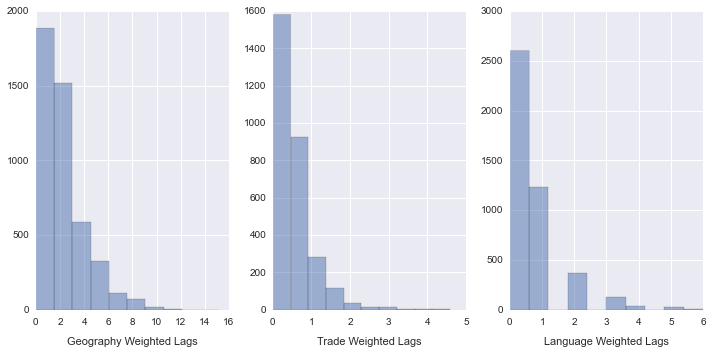

In [9]:
plt.figure(figsize = (10, 5))

plt.subplot(131)
plt.hist(lags_out['lag_failure_geog'].dropna().values, alpha = 0.5)
plt.xlabel('Geography Weighted Lags', labelpad = 10); plt.ylabel('')

plt.subplot(132)
plt.hist(lags_out['lag_failure_trade'].dropna().values, alpha = 0.5)
plt.xlabel('Trade Weighted Lags', labelpad = 10); plt.ylabel('')

plt.subplot(133)
plt.hist(lags_out['lag_failure_lang'].dropna().values, alpha = 0.5)
plt.xlabel('Language Weighted Lags', labelpad = 10); plt.ylabel('')

plt.tight_layout() 